<a href="https://colab.research.google.com/github/blowmeaway1234/Artificial-Intelligence/blob/main/Training_model_Human_Recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Drive Data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/HumanRE

test.zip  train.zip  val.zip


In [5]:
! unzip /content/drive/MyDrive/HumanRE/train.zip
! unzip /content/drive/MyDrive/HumanRE/test.zip
! unzip /content/drive/MyDrive/HumanRE/val.zip

Archive:  /content/drive/MyDrive/HumanRE/train.zip
   creating: train/
   creating: train/0/
  inflating: train/0/no human (10).jpg  
  inflating: train/0/no human (100).jpg  
  inflating: train/0/no human (101).jpg  
  inflating: train/0/no human (102).jpg  
  inflating: train/0/no human (104).jpg  
  inflating: train/0/no human (105).jpg  
  inflating: train/0/no human (106).jpg  
  inflating: train/0/no human (107).jpg  
  inflating: train/0/no human (108).jpg  
  inflating: train/0/no human (109).jpg  
  inflating: train/0/no human (11).jpg  
  inflating: train/0/no human (110).jpg  
  inflating: train/0/no human (111).jpg  
  inflating: train/0/no human (112).jpg  
  inflating: train/0/no human (113).jpg  
  inflating: train/0/no human (114).jpg  
  inflating: train/0/no human (116).jpg  
  inflating: train/0/no human (117).jpg  
  inflating: train/0/no human (118).jpg  
  inflating: train/0/no human (119).jpg  
  inflating: train/0/no human (12).jpg  
  inflating: train/0/no huma

In [6]:
for i in range(3):
  !ls test/{i}| wc -l

for i in range(3):
  !ls val/{i}| wc -l
  
for i in range(3): 
  !ls train/{i}| wc -l

51
111
59
143
262
141
722
851
550


# Build Data Pipe line

In [19]:
# import library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping

In [20]:
# Part data train
train_root = Path('train/')
filelist_Training = tf.data.Dataset.list_files(str(train_root/'*/*')) 

# Part data test
test_root = Path('test/')
filelist_Testing = tf.data.Dataset.list_files(str(test_root/'*/*'))

# Part data validation
val_root = Path('val/')
filelist_Validation = tf.data.Dataset.list_files(str(val_root/'*/*'))  


In [21]:
for file in filelist_Training.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8
for file in filelist_Testing.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8
for file in filelist_Validation.take(2):
  print('filename:',file.numpy().decode('utf-8')) # Decode tf.tensor to utf8

filename: train/2/all body (413).jpg
filename: train/2/all body (460).jpg
filename: test/2/test 2 (6).jpg
filename: test/1/test 1 (49).jpg
filename: val/1/val 1 (230).jpg
filename: val/2/valval (80).jpg


In [22]:
#Preprocessing
def preprocessing(file_path):
  #Readfile
  img1 = tf.io.read_file(file_path)
  img1 = tf.image.decode_jpeg(img1,channels=3) #Read Color image
  img1 = tf.image.rgb_to_grayscale(img1, name=None) # convert to gray scale
  #Transform
  img1 = tf.image.convert_image_dtype(img1,tf.float32) # convert uint8 to float and normalize [0,1]
  #Resize image
  img1 = tf.image.resize(img1,[img_width,img_height])
  #-4. Reshape -> vector hàng
  img1 = tf.reshape(img1,(28,28,1))
  #Get image lable
  label = get_label(file_path) #sự dụng hàm test label vừa tạo
  #Return
  return img1,label#Preprocessing


In [23]:
# Make Label
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  if parts[-2] == "0":
    labels=[1,0,0] 
  elif parts[-2] =="1":
    labels=[0,1,0]
  else:
    labels=[0,0,1] 
  return tf.convert_to_tensor(labels)

In [24]:
#Global Value
batch_size= 32                     
img_height = 28
img_width = 28

datatrain_size = 2123 #(shuffle size_train) 
datatest_size = 221 #(shuffle test) 
dataval_size = 546
reshapesize= img_height*img_width
print("Value Reshapsize",reshapesize)

Value Reshapsize 784


In [25]:
#build data training
train_dataset = filelist_Training.shuffle(datatrain_size) 
train_dataset = train_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(2) # chia luồn data

In [26]:
#build validation data
test_dataset_validation = filelist_Validation.shuffle(dataval_size) 
test_dataset_validation = test_dataset_validation.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
test_dataset_validation = test_dataset_validation.batch(batch_size)
test_dataset_validation = test_dataset_validation.prefetch(2) # chia luồn data

In [27]:
#build data testing
test_dataset = filelist_Testing.shuffle(datatest_size) 
test_dataset = test_dataset.map(preprocessing,num_parallel_calls=tf.data.AUTOTUNE) # Process each element + get labels => train_ds = pixel val and labels
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(2) # chia luồn data

In [28]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

#Build Model


In [29]:
# Build CNN model using function API
# Convolutional Neural Network

# Build CNN model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(img_height, img_width, 1)))
model.add(layers.Conv2D(10, 5, strides=(1, 1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
model.add(layers.Conv2D(20, 5, strides=(1, 1), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy']) # Compile model
model.summary()

# Draw Graph
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dropout_1 (Dropout)         (None, 320)              

#Train Model

Epoch 1/60
67/67 [==============================] - 3s 25ms/step - loss: 0.9239 - accuracy: 0.5827 - val_loss: 0.7925 - val_accuracy: 0.6722
Epoch 2/60
67/67 [==============================] - 2s 24ms/step - loss: 0.7366 - accuracy: 0.6938 - val_loss: 0.6441 - val_accuracy: 0.7381
Epoch 3/60
67/67 [==============================] - 2s 35ms/step - loss: 0.6080 - accuracy: 0.7537 - val_loss: 0.5550 - val_accuracy: 0.7912
Epoch 4/60
67/67 [==============================] - 1s 20ms/step - loss: 0.5113 - accuracy: 0.8088 - val_loss: 0.4651 - val_accuracy: 0.8132
Epoch 5/60
67/67 [==============================] - 1s 20ms/step - loss: 0.4444 - accuracy: 0.8300 - val_loss: 0.5593 - val_accuracy: 0.7985
Epoch 6/60
67/67 [==============================] - 1s 20ms/step - loss: 0.4048 - accuracy: 0.8408 - val_loss: 0.5127 - val_accuracy: 0.7967
Epoch 7/60
67/67 [==============================] - 1s 19ms/step - loss: 0.4217 - accuracy: 0.8436 - val_loss: 0.3786 - val_accuracy: 0.8718
Epoch 8/60
67

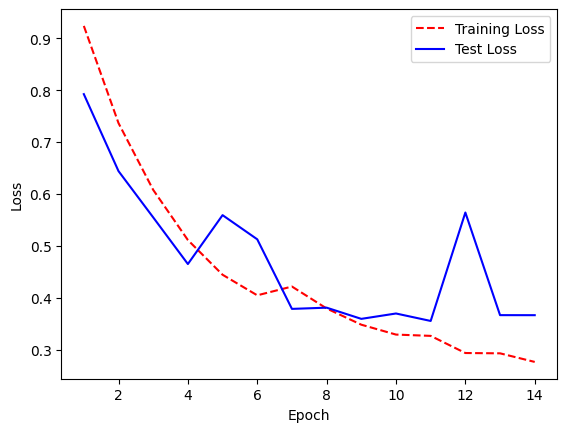

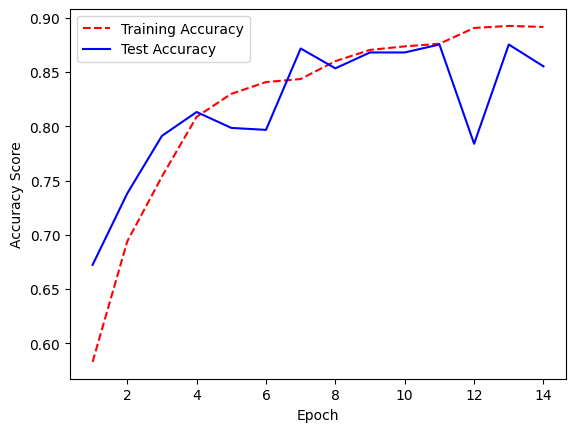

In [30]:
# Train model
history = model.fit(train_dataset, epochs=60, validation_data=test_dataset_validation, callbacks=[early_stopping])

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show()

model.save('CNN_Human_Rec.h5')

# Evaluate

7/7 [==============================] - 0s 22ms/step - loss: 0.2941 - accuracy: 0.8959
Test Loss: 0.29405513405799866
Test Accuracy: 0.8959276080131531
7/7 [==============================] - 0s 19ms/step


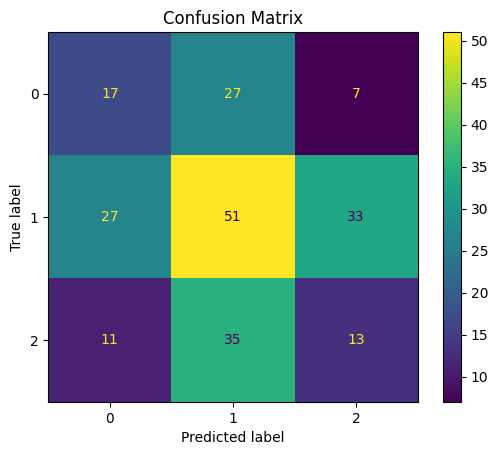

In [31]:
# Evaluate model on test dataset
evaluation = model.evaluate(test_dataset)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Predict the label of the test data file
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to label indices

# Convert actual labels from one-hot encoding to integer format
y_true = []
for _, label in test_dataset:
    y_true.extend(np.argmax(label, axis=1))

#Draw ConFusion MaTrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

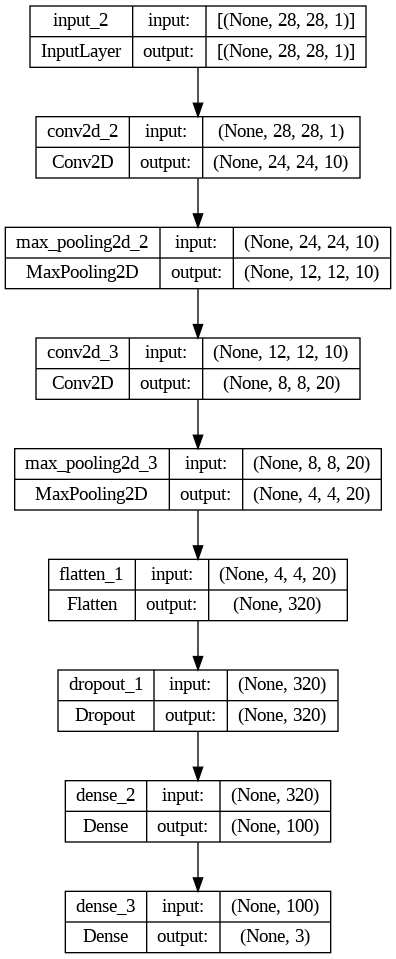

In [32]:
# Draw Graph
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)